<h1> Initialize Boring Stuffs </h1> 

In [36]:
#import libraries and stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

#import mnist from local directory
data = pd.read_csv('mnist/train.csv')

#data_target_split
Y = np.array(data['label'])
Y = np.reshape(Y, (42000, 1))
X = np.array(data[data.columns[1:]])
X = X / 255
X = X.T

Y_Original = np.zeros((42000,10))

#output vector
true_output_matrix = np.identity(10)

#image checking
for i in range(42000):
    Y_Original[i] = Y_Original[i] + true_output_matrix[Y[i]]
    
Y = Y_Original.T
print(X.shape)

# first_sample = np.reshape(X[5], (28, 28))
# plt.imshow(first_sample, cmap='gray')
# plt.show()

(784, 42000)


<h1> Network Structure </h1>

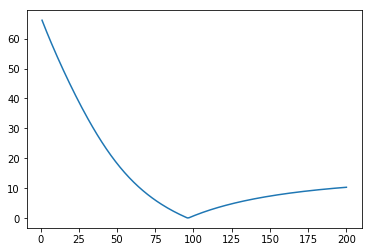

In [37]:
#import sklearn

from sklearn.metrics import mean_squared_error

#initialize the network

class Layer:
    def __init__(self, layer_parameter):
        if(layer_parameter[1]!='none'): 
            self.activations_for_this_layer = np.zeros(layer_parameter[0])
        self.number_of_nodes = layer_parameter[0]
        self.activation_function = layer_parameter[1]
        self.weights_from_previous_layer = layer_parameter[2]
        self.biases_for_this_layer = layer_parameter[3]
        
class NeuralNetwork:
    
    #constructor
    def __init__(self, network_parameter):
        self.number_of_hidden_layers = network_parameter[0]
        self.hidden_layer_size = network_parameter[1]
        self.output_size = network_parameter[2]
        self.layers = []
        self.final_output = 0
        
    #activation functions
    def ReLU(self, x):
        return np.maximum(x, 0)
    
    def sigmoid(self, x):
        return np.divide(1, np.add(1, np.exp(np.negative(x))))
    
    def Dsigmoid(self, x):
        return sigmoid(x) * (1-sigmoid(x))
    
    def softmax(self, x):
        exp = np.exp(x)
        if isinstance(x[0], np.ndarray):
            return exp/np.sum(exp, axis=1, keepdims=True)
        else:
            return exp/np.sum(exp, keepdims=True)
    
    def tanh(self, x):
        return np.divide(np.exp(x)-np.exp(np.negative(x)) , np.exp(x)+np.exp(np.negative(x)))
    
    def Dtanh(self, x):
        return (1-self.tanh(x)**2)
    
    #network structure define
    def structure_define(self):
        
        #create input layer
        input_layer = Layer([784, 'none', [], []])
        self.layers.append(input_layer)

        #create hidden layer 1
        np.random.seed(1)
        hidden_layer_1_weights = np.random.randn(16, 784) * 0.01
        hidden_layer_1_biases = np.random.randn(16, 1)
        hidden_layer_1 = Layer([16, 'Tanh', hidden_layer_1_weights, hidden_layer_1_biases])
        self.layers.append(hidden_layer_1)

        #create hidden layer 2
        np.random.seed(2)
        hidden_layer_2_weights = np.random.randn(16, 16) * 0.01
        hidden_layer_2_biases = np.random.randn(16, 1)
        hidden_layer_2 = Layer([16, 'Tanh', hidden_layer_2_weights, hidden_layer_2_biases])
        self.layers.append(hidden_layer_2)

        #create output layer
        np.random.seed(3)
        output_layer_weights = np.random.randn(10, 16) * 0.01
        output_layer_biases = np.random.randn(10, 1)
        output_layer = Layer([10, 'Sigmoid', output_layer_weights, output_layer_biases])
        self.layers.append(output_layer)
            
    def forward_propagation(self): 
        
        # Hidden Layer 1
        self.W_1 = self.layers[1].weights_from_previous_layer
        self.B_1 = self.layers[1].biases_for_this_layer
        self.Z_1 = np.dot(self.W_1, X) + self.B_1
        self.A_1 = self.tanh(self.Z_1)
        
        #Hidden Layer 2
        self.W_2 = self.layers[2].weights_from_previous_layer
        self.B_2 = self.layers[2].biases_for_this_layer
        self.Z_2 = np.dot(self.W_2, self.A_1) + self.B_2
        self.A_2 = self.tanh(self.Z_2)
        
        #Hidden Layer 3
        self.W_3 = self.layers[3].weights_from_previous_layer
        self.B_3 = self.layers[3].biases_for_this_layer
        self.Z_3 = np.dot(self.W_3, self.A_2) + self.B_3
        self.A_3 = self.sigmoid(self.Z_3)
    
    def calculate_network_loss(self):
        loss = (abs(1/42000 * np.sum((-1) * (np.dot(Y, np.log(self.A_3.T))) + np.dot((1-Y),(np.log(1-self.A_3.T))))))
        return loss
        
    def backward_propagation(self):
        
        #Output Layer
        self.dZ_3 = self.A_3 - Y
        self.dW_3 = 1/42000 * np.dot(self.dZ_3, self.A_2.T)
        self.dB_3 = 1/42000 * np.sum(self.dZ_3, axis=1, keepdims=True)
        
        #Hidden Layer 2
        self.dZ_2 = np.multiply(np.dot(self.W_3.T, self.dZ_3), self.Dtanh(self.Z_2))
        self.dW_2 = 1/42000 * np.dot(self.dZ_2, self.A_1.T)
        self.dB_2 = self.dZ_2 
        
        #Hidden Layer 1
        self.dZ_1 = np.multiply(np.dot(self.W_2.T, self.dZ_2), self.Dtanh(self.Z_1))
        self.dW_1 = 1/42000 * np.dot(self.dZ_1, X.T)
        self.dB_1 = self.dZ_1 
        
        #Weight Update
        self.layers[1].weights_from_previous_layer = self.layers[1].weights_from_previous_layer - 0.01 * self.dW_1
        self.layers[1].biases_for_this_layer = self.layers[1].biases_for_this_layer - 0.001 * self.dB_1
        
        self.layers[2].weights_from_previous_layer = self.layers[2].weights_from_previous_layer - 0.01 * self.dW_2
        self.layers[2].biases_for_this_layer = self.layers[2].biases_for_this_layer - 0.001 * self.dB_2
        
        self.layers[3].weights_from_previous_layer = self.layers[3].weights_from_previous_layer - 0.01 * self.dW_3
        self.layers[3].biases_for_this_layer = self.layers[3].biases_for_this_layer - 0.001 * self.dB_3
        
        
#initialize network
PSO_Net = NeuralNetwork([2, 16, 10])
PSO_Net.structure_define()
epoch = np.arange(1, 201)
loss = np.zeros((200, 1))

for i in range(200):
    PSO_Net.forward_propagation()
    loss[i] = PSO_Net.calculate_network_loss()
    PSO_Net.backward_propagation()
    
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
def animate(i):
    ax1.clear()
    ax1.plot(epoch, loss)
ani = animation.FuncAnimation(fig, animate, interval=1000)
plt.show()
    
    